# 📊 Unión y Limpieza de datos del Dataset  

---

**Objetivo del Notebook**  
Limpieza de datos, columnas innecesarias y valores nulos/blancos 

**Contexto del análisis**  
- Dataset de muestra proporcionado + csv proporcionado unido en un único excel dataset
- Enfoque en aprendizaje, validación del pipeline y comprensión del proceso

**Valor devuelto**  
- Copia del Dataset de muestra proporcionado completamente limpio y útil 

---




In [9]:
import pandas as pd
import xlsxwriter
import utils
# ===============================
# LEER EL ARCHIVO LIMPIO
# ===============================
ruta = r"C:\Users\0017655\Downloads\DataSET_SF - V2.xlsx"
dfs = pd.read_excel(ruta, sheet_name=None)

# Ver la primera hoja
oportunidad = list(dfs.values())[0]
cuenta = list(dfs.values())[1]
ecb = list(dfs.values())[2]
solicitud_ban = list(dfs.values())[3]
casos = list(dfs.values())[4]
correos = list(dfs.values())[5]
historial_actividad = list(dfs.values())[6]
historial_etapas = list(dfs.values())[7]


print(historial_etapas.head())

    LK_Oportunidad__c  PL_Etapa__c PL_Subetapa__c  \
0  0061r00001Eoi9EAAR  Información       Recibida   
1  0061r00001EatFpAAJ  Información       Recibida   
2  0061r00001DdSqlAAF  Información            NaN   
3  0061r00001Ddf1fAAB  Información            NaN   
4  0061r00001FGXaYAAX  Información       Recibida   

                    CreatedDate  CH_Completa_principal__c  \
0  2020-04-29T15:07:11.000+0000                     False   
1  2020-03-04T17:56:10.000+0000                     False   
2  2020-03-31T14:22:24.000+0000                     False   
3  2020-04-03T07:48:09.000+0000                     False   
4  2020-04-07T21:42:33.000+0000                     False   

             Fecha_fin_etapa__c  
0  2022-10-03T13:40:18.000+0000  
1  2021-10-03T20:22:36.000+0000  
2  2021-10-31T09:09:40.000+0000  
3  2021-11-09T16:50:17.000+0000  
4  2021-12-24T21:00:35.000+0000  


In [10]:
from utils import analisis_na_por_columna
analisis_na_por_columna(oportunidad)
analisis_na_por_columna(cuenta)
analisis_na_por_columna(ecb)
analisis_na_por_columna(solicitud_ban)
analisis_na_por_columna(casos)
analisis_na_por_columna(correos)
analisis_na_por_columna(historial_actividad)
analisis_na_por_columna(historial_etapas)

,columna,total_na,porcentaje_na
0,PL_Subetapa__c,119841,22.334436
1,Fecha_fin_etapa__c,69864,13.020361
2,LK_Oportunidad__c,0,0.000000
3,PL_Etapa__c,0,0.000000
4,CreatedDate,0,0.000000
5,CH_Completa_principal__c,0,0.000000


In [14]:
from utils import analisis_na_por_columna, eliminar_columnas_na, crear_target


# ===============================
# LIMPIEZA DE NAS
# ===============================

oportunidad = eliminar_columnas_na(oportunidad)
cuenta = eliminar_columnas_na(cuenta)
ecb = eliminar_columnas_na(ecb)
solicitud_ban = eliminar_columnas_na(solicitud_ban)
casos = eliminar_columnas_na(casos)
correos = eliminar_columnas_na(correos)
historial_actvidad = eliminar_columnas_na(historial_actividad)
historial_etapas = eliminar_columnas_na(historial_etapas)

# ===============================
# CREACION DEL TARJET
# ===============================

target = crear_target(oportunidad, historial_etapas)
target.columns




Hay un total de 15470 matrículas formalizadas. Un 22.03% del total de oportunidades
Hay un total de 1495 desmatriculados. Un 9.66% del total de matriculados


Index(['ID', 'ACCOUNTID', 'PL_CURSO_ACADEMICO', 'PL_MES_ANIO_INICIO',
       'PL_TIPO_ACCESO', 'RECORDTYPEID', 'RECORDTYPENAME', 'PL_ESTADO',
       'STAGENAME', 'PL_SUBETAPA', 'CH_SIMULTANEIDAD', 'CH_COMPLETA',
       'CAMBIA_DE_CARRERA', 'PL_GESTIONADO_POR', 'CH_NACIONAL',
       'CH_INTERNACIONAL', 'PL_ORIGEN_DE_SOLICITUD', 'PL_FORMATO',
       'CH_ORIGEN_ADMISION', 'CLOSEDATE', 'LEADSOURCE', 'PL_ORIGEN_FORMULARIO',
       'PL_PLAZO_ADMISION', 'LK_CALENDARIO_DE_ADMISION', 'CALENDARIO_ADMISION',
       'LK_CALENDARIO_DE_ADMISION_FINA', 'CALENDARIO_ADMISION_FINAL',
       'CONVOCATORIANOMBRE', 'NU_NOTA_MEDIA_ADMISION',
       'CH_PRUEBAS_CALIFICADAS', 'NU_RESULTADO_ADMISION_PUNTOS', 'CH_STANDBY',
       'NU_PREFERENCIA', 'LK_TITULACION', 'TITULACION',
       'LK_TITULACION_DEFINITIVA', 'TITULACION_DEF',
       'LK_TITULACION_POR_CURSO_ACADEMICO__C', 'TITULACION_CURSO',
       'CU_IMPORTE_MATRICULA', 'LK_TITULACION_POR_CURSO_ACADEMICO_FINAL__C',
       'TITULACION_CURSO_FIN', 'PL_RESOL

# Análisis descriptivo (Seguimiento 1)

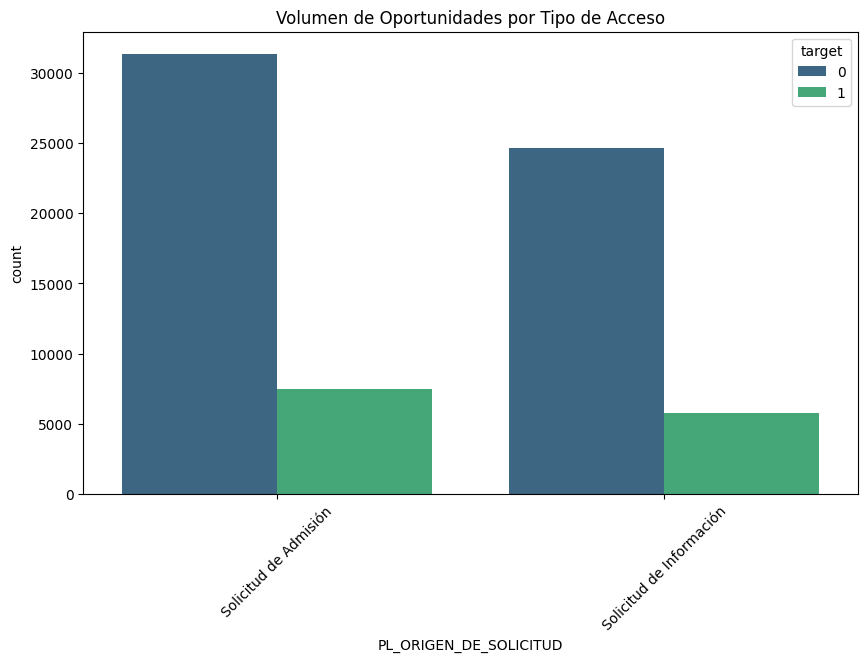

No Matriculado (0)  \
PL_CURSO_ACADEMICO PL_ORIGEN_DE_SOLICITUD                         
2022/2023          Solicitud de Admisión                   6303   
                   Solicitud de Información                5293   
2023/2024          Solicitud de Admisión                   6379   
                   Solicitud de Información                5422   
2024/2025          Solicitud de Admisión                   6362   
                   Solicitud de Información                5009   
2025/2026          Solicitud de Admisión                   6614   
                   Solicitud de Información                4848   
2026/2027          Solicitud de Admisión                   5726   
                   Solicitud de Información                4057   

                                             Matriculado (1)  Total  \
PL_CURSO_ACADEMICO PL_ORIGEN_DE_SOLICITUD                             
2022/2023          Solicitud de Admisión                1811   8114   
                   Solicitud de Información             1448   6741   
2023/2024          Solicitud de Admisión                1790   8169   
                   Solicitud de Información             1356   6778   
2024/2025          Solicitud de Admisión                1824   8186   
                   Solicitud de Información             1410   6419   
2025/2026          Solicitud de Admisión                2062   8676   
                   Solicitud de Información             1573   6421   
2026/2027          Solicitud de Admisión                   0   5726   
                   Solicitud de Información                0   4057   

                                             % Fidelidad  
PL_CURSO_ACADEMICO PL_ORIGEN_DE_SOLICITUD                 
2022/2023          Solicitud de Admisión           22.32  
                   Solicitud de Información        21.48  
2023/2024          Solicitud de Admisión           21.91  
                   Solicitud de Información        20.01  
2024/2025          Solicitud de Admisión           22.28  
                   Solicitud de Información        21.97  
2025/2026          Solicitud de Admisión           23.77  
                   Solicitud de Información        24.50  
2026/2027          Solicitud de Admisión            0.00  
                   Solicitud de Información         0.00

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Resumen numérico con cálculo de porcentaje
resumen_acceso = target.groupby(['PL_CURSO_ACADEMICO', 'PL_ORIGEN_DE_SOLICITUD', 'target'])['ID'].nunique().unstack(fill_value=0)
resumen_acceso.columns = ['No Matriculado (0)', 'Matriculado (1)']

# Calcular Total y % de Matriculados (Tasa de Conversión/Fidelidad)
resumen_acceso['Total'] = resumen_acceso['No Matriculado (0)'] + resumen_acceso['Matriculado (1)']
resumen_acceso['% Fidelidad'] = (resumen_acceso['Matriculado (1)'] / resumen_acceso['Total'] * 100).round(2)


# Gráfico Global de Acceso
plt.figure(figsize=(10, 6))
sns.countplot(data=target.drop_duplicates('ID'), x='PL_ORIGEN_DE_SOLICITUD', hue='target', palette='viridis')
plt.title('Volumen de Oportunidades por Tipo de Acceso')
plt.xticks(rotation=45)
plt.show()
resumen_acceso

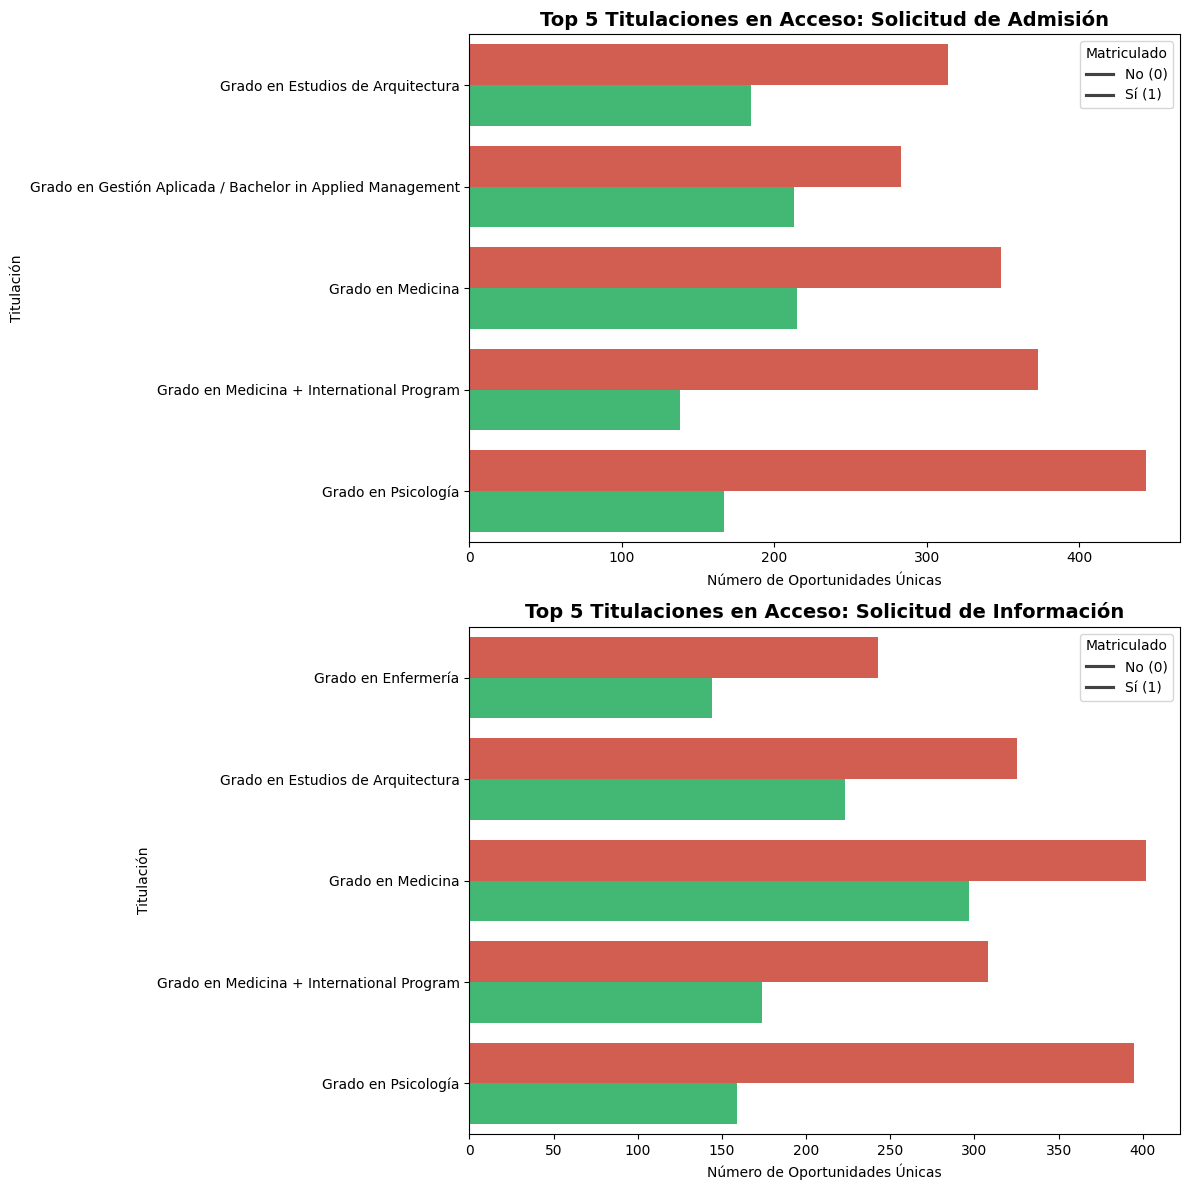

In [16]:
from utils import graficar_top_por_acceso
import matplotlib.pyplot as plt
# Ejecución
graficar_top_por_acceso(target, top_n=5)

In [18]:
columnas_seleccionadas = [
    # Identificadores y Target
    'ACCOUNTID', 'ID','ID18__PC', 'target', 'PL_CURSO_ACADEMICO',
    
    # Rendimiento Académico
    'NU_NOTA_MEDIA_ADMISION', 'NU_NOTA_MEDIA_1_BACH__PC', 'CH_PRUEBAS_CALIFICADAS', 
    'NU_RESULTADO_ADMISION_PUNTOS', 'PL_RESOLUCION_DEFINITIVA', 'TITULACION',
    
    # Compromiso Económico
    'MINIMUMPAYMENTPAYED', 'PAID_AMOUNT', 'PAID_PERCENT', 'CH_PAGO_SUPERIOR', 
    'CH_MATRICULA_SUJETA_BECA', 'CH_AYUDA_FINANCIACION', 'CU_IMPORTE_TOTAL',
    
    # Engagement y Actividad
    'CH_VISITACAMPUS__PC', 'CH_ENTREVISTA_PERSONAL__PC', 'ACC_DTT_FECHAULTIMAACTIVIDAD', 
    'NU_PREFERENCIA', 'STAGENAME', 'PL_SUBETAPA',
    
    # Perfil Sociodemográfico y Fidelidad
    'CH_HIJO_EMPLEADO__PC', 'CH_HIJO_ANTIGUO_ALUMNO__PC', 'CH_HERMANOS_ESTUDIANDO_UNAV__P', 
    'YEARPERSONBIRTHDATE', 'NAMEX', 'CH_FAMILIA_NUMEROSA__PC', 'PL_SITUACION_SOCIO_ECONOMICA',
    
    # Origen y Canal
    'LEADSOURCE', 'PL_ORIGEN_DE_SOLICITUD', 'LK_CENTROENSENANZA', 'PL_PLAZO_ADMISION'
]


# Unir la tabla con cuenta y obtener filtrar los datos que nos interesen
df_unido = pd.merge(
    target, 
    cuenta, 
    left_on='ACCOUNTID', 
    right_on='ID18', 
    how='left',
    suffixes=('', '_cuenta')
)		
columnas_finales =  [col for col in columnas_seleccionadas if col in df_unido.columns]
df_unido_filtrado =  df_unido[columnas_finales].copy()


In [20]:
from utils import calcular_tiempos_etapas, limpiar_historial_por_hitos
import numpy as np
import pandas as pd

historial_etapas_tiempo = calcular_tiempos_etapas(historial_etapas)

import pandas as pd
import numpy as np


df_final = limpiar_historial_por_hitos(historial_etapas_tiempo, df_unido_filtrado)

ejemplo_id = '0066900001k7yTgAAI'

columnas_comprobacion = [
    'LK_Oportunidad__c', 'CreatedDate', 'PL_Etapa__c', 'PL_Subetapa__c',
    'fecha_pruebas_calificadas', 'NU_NOTA_MEDIA_ADMISION',
    'fecha_matricula_iniciada', 'PAID_AMOUNT','NU_NOTA_MEDIA_ADMISION', 'CH_PRUEBAS_CALIFICADAS', 
        'NU_RESULTADO_ADMISION_PUNTOS', 'PL_RESOLUCION_DEFINITIVA'
]

print("--- COMPROBACIÓN DE LÓGICA TEMPORAL ---")
df_final[df_final['LK_Oportunidad__c'] == ejemplo_id][columnas_comprobacion].sort_values('CreatedDate')
#df_final.head(50)

--- COMPROBACIÓN DE LÓGICA TEMPORAL ---


,LK_Oportunidad__c,CreatedDate,PL_Etapa__c,PL_Subetapa__c,fecha_pruebas_calificadas,NU_NOTA_MEDIA_ADMISION,fecha_matricula_iniciada,PAID_AMOUNT,NU_NOTA_MEDIA_ADMISION,CH_PRUEBAS_CALIFICADAS,NU_RESULTADO_ADMISION_PUNTOS,PL_RESOLUCION_DEFINITIVA
289214,0066900001k7yTgAAI,2023-10-27 21:39:16+00:00,Información,Recibida,2025-01-10 20:52:21+00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN
289215,0066900001k7yTgAAI,2024-10-22 17:15:58+00:00,Inicio,NaN,2025-01-10 20:52:21+00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN
289216,0066900001k7yTgAAI,2024-10-22 17:52:52+00:00,Validación,Recibida,2025-01-10 20:52:21+00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN
289217,0066900001k7yTgAAI,2024-10-23 06:38:41+00:00,Validación,Completa,2025-01-10 20:52:21+00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN
289218,0066900001k7yTgAAI,2024-11-21 11:15:36+00:00,Pruebas de admisión,Convocado,2025-01-10 20:52:21+00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN
289219,0066900001k7yTgAAI,2024-12-09 10:02:17+00:00,Validación,Completa,2025-01-10 20:52:21+00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN
289220,0066900001k7yTgAAI,2024-12-09 10:02:36+00:00,Pruebas de admisión,Convocado,2025-01-10 20:52:21+00:00,NaN,NaT,NaN,NaN,NaN,NaN,NaN
289221,0066900001k7yTgAAI,2025-01-10 20:52:21+00:00,Pruebas de admisión,Pruebas calificadas,2025-01-10 20:52:21+00:00,7.78,NaT,NaN,7.78,True,8.51,Admitido
289222,0066900001k7yTgAAI,2025-01-10 21:33:23+00:00,Estudio Centro,Recibida,2025-01-10 20:52:21+00:00,7.78,NaT,NaN,7.78,True,8.51,Admitido
289223,0066900001k7yTgAAI,2025-01-19 21:31:07+00:00,Estudio Centro,Resuelta,2025-01-10 20:52:21+00:00,7.78,NaT,NaN,7.78,True,8.51,Admitido


In [25]:
import pandas as pd
import numpy as np
from utils import integrar_actividades_progresivo_por_curso
# Ejecución
df_final_v3 = integrar_actividades_progresivo_por_curso(df_final, historial_actividad)
# ==========================================
# EJECUCIÓN
# ==========================================
# Print de comprobación para ver la evolución de un contacto
ejemplo_acc = df_final_v3[df_final_v3['num_asistencias_acum'] > 0]['ID18__PC'].iloc[1]
cols_print = ['ID','ID18__PC','ACCOUNTID', 'CreatedDate', 'PL_Etapa__c', 'num_asistencias_acum', 'num_solicitudes_acum']

print("\n--- COMPROBACIÓN DE EVOLUCIÓN DE ACTIVIDADES ---")
df_final_v3[df_final_v3['ID18__PC'] == ejemplo_acc][cols_print].sort_values('CreatedDate')
#historial_actividad.loc[historial_actividad['ContactId']=='003690000312P6pAAE',]
df_final_v3.head(100)
df_integrado = df_final_v3

Procesando 536575 filas con lógica de curso y progresión temporal...
Cruzando datos por ID18__PC y Curso Académico...
Aplicando filtro temporal progresivo...
Agrupando resultados...
Consolidando en el DataFrame maestro...
✅ Proceso completado.

--- COMPROBACIÓN DE EVOLUCIÓN DE ACTIVIDADES ---


In [ ]:
# ===============================
# 3. GUARDAR EXCEL LIMPIO
# ===============================
#df_integrado.to_csv(r"..\datos\02. Datos tratamiento preliminar\01_datos_tratamiento_preliminar - V2.csv",sep=";")

print("Archivo limpio guardado como '01_datos_tratamiento_preliminar - V2.csv'")

# 📊 Creación del Dataset Maestro

---

**Objetivo del Notebook**  
Creacion del dataset maestro una vez obtenido el dataset limpio

**Contexto del análisis**  
- Dataset limpio en etapas anteriores

**Valor devuelto**  
- Copia del Dataset de muestra proporcionado completamente funcional

---




TAREA 1: Comprobar que el conjunto de datos contiene todas las variables importantes de la pestaña de cuenta: Variables relacionadas con el origen del alumno: nacional o internacional, colegio de procedencia, si el colegio es afín o no a la UNAV, si es hijo de empleado o de profesor asociado (por los descuentos en matrícula), si es familia numerosa y de qué tipo.

In [ ]:
# ===============================
# VARIABLES CLAVE ESPERADAS (CUENTA)
# ===============================

variables_cuenta_clave = {
    "Origen del alumno": [
        "PL_NACIONALIDAD__C",          # cambiar por colegio
        "PL_TIPO_ALUMNO__C"            # Nacional / Internacional (alternativa frecuente)
    ],
    
    "Colegio de procedencia": [
        "CENTROENSENANZA",
        "CH_CENTRO_AFIN_UNAV__C"       # Colegio afín a UNAV, añadir nota media 1º bachillerato, hijo empleado, hijo medico, hijo hermanos en la unav, etc
    ],
    
    "Vínculo con UNAV (descuentos)": [
        "CH_HIJO_EMPLEADO__PC",
        "CH_HIJO_PROFESOR_ASOCIADO__C" # si existe
    ],
    
    "Familia numerosa": [
        "CH_FAMILIA_NUMEROSA__PC",
        "PL_TIPO_FAMILIA_NUMEROSA__C"  # general / especial, añadir nº miembros de la familia, 
    ]
}



In [28]:
# ===============================
# COMPROBACIÓN DE EXISTENCIA EN CUENTA: verificamos qué está y qué falta realmente en el dataframe cuenta.
# ===============================

columnas_cuenta = set(cuenta.columns)

estado_variables = []

for bloque, vars_bloque in variables_cuenta_clave.items():
    for var in vars_bloque:
        estado_variables.append({
            "Bloque": bloque,
            "Variable": var,
            "Existe_en_cuenta": var in columnas_cuenta
        })

df_estado_variables = pd.DataFrame(estado_variables)
df_estado_variables


,Bloque,Variable,Existe_en_cuenta
0,Origen del alumno,PL_NACIONALIDAD__C,False
1,Origen del alumno,PL_TIPO_ALUMNO__C,False
2,Colegio de procedencia,LK_CENTROENSENANZA,False
3,Colegio de procedencia,CH_CENTRO_AFIN_UNAV__C,False
4,Vínculo con UNAV (descuentos),CH_HIJO_EMPLEADO__PC,True
5,Vínculo con UNAV (descuentos),CH_HIJO_PROFESOR_ASOCIADO__C,False
6,Familia numerosa,CH_FAMILIA_NUMEROSA__PC,True
7,Familia numerosa,PL_TIPO_FAMILIA_NUMEROSA__C,False


In [29]:
# ===============================
# COMPROBAR PRESENCIA EN DATASET FINAL: comprobamos si esas variables han sobrevivido al cruce y están en el dataset final.
# ===============================

columnas_final = set(df_integrado.columns)

df_estado_variables["Existe_en_df_integrado"] = (
    df_estado_variables["Variable"].isin(columnas_final)
)

df_estado_variables


,Bloque,Variable,Existe_en_cuenta,Existe_en_df_integrado
0,Origen del alumno,PL_NACIONALIDAD__C,False,False
1,Origen del alumno,PL_TIPO_ALUMNO__C,False,False
2,Colegio de procedencia,LK_CENTROENSENANZA,False,True
3,Colegio de procedencia,CH_CENTRO_AFIN_UNAV__C,False,False
4,Vínculo con UNAV (descuentos),CH_HIJO_EMPLEADO__PC,True,True
5,Vínculo con UNAV (descuentos),CH_HIJO_PROFESOR_ASOCIADO__C,False,False
6,Familia numerosa,CH_FAMILIA_NUMEROSA__PC,True,True
7,Familia numerosa,PL_TIPO_FAMILIA_NUMEROSA__C,False,False


In [30]:
# ===============================
# CALIDAD DE VARIABLES EXISTENTES: Para las que sí existen en df_integrado, comprobamos si tienen datos útiles.
# ===============================

vars_validas = df_estado_variables.loc[
    df_estado_variables["Existe_en_df_integrado"],
    "Variable"
].tolist()

calidad = (
    df_integrado[vars_validas]
    .isna()
    .mean()
    .reset_index()
    .rename(columns={"index": "Variable", 0: "% NA"})
)

calidad["% NA"] = (calidad["% NA"] * 100).round(2)
calidad.sort_values("% NA", ascending=False)


,Variable,% NA
0,LK_CENTROENSENANZA,9.37
1,CH_HIJO_EMPLEADO__PC,0.00
2,CH_FAMILIA_NUMEROSA__PC,0.00


In [ ]:
# ===============================
# CONCLUSIÓN AUTOMÁTICA
# ===============================

conclusion = df_estado_variables.copy()
conclusion["Estado"] = np.select(
    [
        ~conclusion["Existe_en_cuenta"],
        conclusion["Existe_en_cuenta"] & ~conclusion["Existe_en_df_integrado"],
        conclusion["Existe_en_df_integrado"]
    ],
    [
        "❌ No existe en origen",
        "⚠️ Existe en cuenta pero no llegó al dataset final",
        "✅ Disponible en dataset final"
    ]
)

conclusion

#REVISAR LA NACIONALIDAD POR SI SE LLAMA DISTINTO (EN EL EXCEL)
# Juan: aquí hay que comprobar en el Excel si los valores que no exixsten en el origen están en el Excel y no aparecen porque se llama de otra forma o si es porque directamente no aparecen y habría que solicitarlos


,Bloque,Variable,Existe_en_cuenta,Existe_en_df_integrado,Estado
0,Origen del alumno,PL_NACIONALIDAD__C,False,False,❌ No existe en origen
1,Origen del alumno,PL_TIPO_ALUMNO__C,False,False,❌ No existe en origen
2,Colegio de procedencia,LK_CENTROENSENANZA,False,True,❌ No existe en origen
3,Colegio de procedencia,CH_CENTRO_AFIN_UNAV__C,False,False,❌ No existe en origen
4,Vínculo con UNAV (descuentos),CH_HIJO_EMPLEADO__PC,True,True,✅ Disponible en dataset final
5,Vínculo con UNAV (descuentos),CH_HIJO_PROFESOR_ASOCIADO__C,False,False,❌ No existe en origen
6,Familia numerosa,CH_FAMILIA_NUMEROSA__PC,True,True,✅ Disponible en dataset final
7,Familia numerosa,PL_TIPO_FAMILIA_NUMEROSA__C,False,False,❌ No existe en origen


TAREA 2: Comprobar que el target se ha creado correctamente, que no hay valores vacíos. En caso de tener valores vacíos, comprobar de donde vienen y porqué ocurren. Comprobar que las variables importantes de oportunidad aparecen en el conjunto de datos: tipo de solicitud (Información o admisión), plazo de admisión(con un tratamiento de si es Diciembre, Marzo o Rolling [que es cuando solicitas la prueba y la haces a los días, suele aparecer en blanco] y tratar de construir bien esta variable), nu_preferencia (con el orden de preferencia), si ha pagado, el pago mínimo, notas de admisión, etc. Asegurar que no aparece información de futuro en etapas anteriores. 


In [ ]:
# ===============================
# VALIDACIÓN BÁSICA DEL TARGET
# ===============================

print("Valores únicos del target:")
print(df_integrado['target'].value_counts(dropna=False))

print("\nNúmero de target nulos:")
print(df_integrado['target'].isna().sum())

# ===============================
# ANÁLISIS DE TARGET NULOS
# ===============================

target_nulos = df_integrado[df_integrado['target'].isna()]

print(f"Registros con target nulo: {len(target_nulos)}")

target_nulos[['ID', 'STAGENAME', 'PL_SUBETAPA']].head()

# ===============================
# COMPROBAR ORIGEN DEL PROBLEMA
# ===============================

ids_target_nulo = set(target_nulos['ID'])
ids_historial = set(historial_etapas['LK_Oportunidad__c'])

print("IDs con target nulo SIN historial:",
      len(ids_target_nulo - ids_historial))
# Juan: El target que sea nulo hay que eliminarlo, ya que no se puede modelar con target nulo. Este caso es seguro uno de los casos sensibles eliminados.

Valores únicos del target:
target
0.0    327854
1.0    208715
NaN         6
Name: count, dtype: int64

Número de target nulos:
6
Registros con target nulo: 6
IDs con target nulo SIN historial: 1


In [33]:
# ===============================
# VARIABLES CLAVE DE OPORTUNIDAD
# ===============================

variables_op_clave = {
    "Tipo de solicitud": [
        "PL_ORIGEN_DE_SOLICITUD",  # Información / Admisión
        "CH_ORIGEN_ADMISION"
    ],
    
    "Plazo de admisión": [
        "PL_PLAZO_ADMISION"
    ],
    
    "Preferencia": [
        "NU_PREFERENCIA"
    ],
    
    "Pago": [
        "CH_PAGADO__C",
        "MINIMUMPAYMENTPAYED",
        "IMPORTE_MINIMO_PERSONALIZADO"
    ],
    
    "Notas admisión": [
        "NU_NOTA_MEDIA_ADMISION",
        "NU_RESULTADO_ADMISION_PUNTOS"
    ]
}

# ===============================
# EXISTENCIA DE VARIABLES
# ===============================

estado_op = []

for bloque, vars_bloque in variables_op_clave.items():
    for var in vars_bloque:
        estado_op.append({
            "Bloque": bloque,
            "Variable": var,
            "Existe_en_df_integrado": var in df_integrado.columns
        })

df_estado_op = pd.DataFrame(estado_op)
df_estado_op


,Bloque,Variable,Existe_en_df_integrado
0,Tipo de solicitud,PL_ORIGEN_DE_SOLICITUD,True
1,Tipo de solicitud,CH_ORIGEN_ADMISION,False
2,Plazo de admisión,PL_PLAZO_ADMISION,True
3,Preferencia,NU_PREFERENCIA,True
4,Pago,CH_PAGADO__C,False
5,Pago,MINIMUMPAYMENTPAYED,True
6,Pago,IMPORTE_MINIMO_PERSONALIZADO,False
7,Notas admisión,NU_NOTA_MEDIA_ADMISION,True
8,Notas admisión,NU_RESULTADO_ADMISION_PUNTOS,True


In [ ]:
df_integrado['PL_PLAZO_ADMISION'].value_counts(dropna=False)

# ===============================
# CONSTRUCCIÓN PLAZO LIMPIO
# ===============================

def normalizar_plazo(x):
    if pd.isna(x):
        return "Rolling"
    x = x.strip().lower()
    if "dic" in x:
        return "Diciembre"
    if "mar" in x:
        return "Marzo"
    return "Otros"

df_integrado['PLAZO_ADMISION_LIMPIO'] = (
    df_integrado['PL_PLAZO_ADMISION']
    .apply(normalizar_plazo)
)

df_integrado['PLAZO_ADMISION_LIMPIO'].value_counts()
df_integrado['PL_PLAZO_ADMISION'].value_counts()

#Juan: Aquí me surge la duda, ya que ellos dijeron que las pruebas son Diciembre, Marzo y Rolling, pero cuando vemos el Plazo de admisión, hay en casi todos los meses, ¿entra en la de diciembre la de noviembre? ¿Y en la de marzo entra febrero y abril? o que nos digan cómo podemos detectar cuando es Rolling o no.

# Juan: Master ponerlo siempre a Rolling, y el resto dejarlo con la lógica de Diciembre, Marzo y Rolling. Después hacer un estudio valuecounts por Plazo en bruto, plazo limpio y tipo de carrera: grado o máster

PL_PLAZO_ADMISION
Diciembre     184478
Octubre        89441
Marzo          78561
Abril          67953
Febrero        45389
Junio          17456
Mayo           14005
Julio          13949
Septiembre      4142
Noviembre       2247
Enero           2180
Agosto            37
Anual              1
Name: count, dtype: int64

In [43]:
# ===============================
# COMPROBACIÓN VARIABLES ECONÓMICAS Y DE PAGO
# ===============================

# Variables económicas que queremos analizar
vars_pago_esperadas = [
    'CH_PAGADO__C',
    'MINIMUMPAYMENTPAYED',
    'IMPORTE_MINIMO_PERSONALIZADO',
    'PAID_AMOUNT',
    'PAID_PERCENT'
]

# Filtrar solo las columnas que existen en df_integrado
vars_pago_existentes = [v for v in vars_pago_esperadas if v in df_integrado.columns]

# Mostrar cuáles existen y cuáles no
print("Variables encontradas en df_integrado:", vars_pago_existentes)
vars_faltantes = [v for v in vars_pago_esperadas if v not in df_integrado.columns]
if vars_faltantes:
    print("⚠️ Variables no encontradas en df_integrado (no se incluyen en análisis):", vars_faltantes)

# Descripción estadística solo de las variables existentes
if vars_pago_existentes:
    print("\n--- Descripción de las variables de pago existentes ---")
    display(df_integrado[vars_pago_existentes].describe())
else:
    print("❌ Ninguna de las variables de pago esperadas está disponible en df_integrado.")

# ===============================
# DETECCIÓN DE INFORMACIÓN FUTURA
# ===============================

# Ejemplo: comprobar pagos antes de la etapa Matrícula
if 'PAID_AMOUNT' in df_integrado.columns:
    casos_incoherentes = df_integrado[
        (df_integrado['PL_Etapa__c'] != 'Matrícula') &
        (df_integrado['PAID_AMOUNT'] > 0)
    ]
    print(f"\n⚠️ Casos con pagos antes de Matrícula: {len(casos_incoherentes)}")
    display(casos_incoherentes[['ID','PL_Etapa__c','PAID_AMOUNT','target']])

#Juan: Comprobación que la variable está bien construida:
df_integrado[[
    'MINIMUMPAYMENTPAYED',
    'PAID_AMOUNT',
    'PAID_PERCENT'
]] # No hay registros donde se pague algo, SIEMPRE VIENEN A NAN 

df_integrado.loc[df_integrado['PAID_AMOUNT']>0,]

Variables encontradas en df_integrado: ['MINIMUMPAYMENTPAYED', 'PAID_AMOUNT', 'PAID_PERCENT']
⚠️ Variables no encontradas en df_integrado (no se incluyen en análisis): ['CH_PAGADO__C', 'IMPORTE_MINIMO_PERSONALIZADO']

--- Descripción de las variables de pago existentes ---


,MINIMUMPAYMENTPAYED,PAID_AMOUNT,PAID_PERCENT
count,0.0,0.0,0.0
mean,NaN,NaN,NaN
std,NaN,NaN,NaN
min,NaN,NaN,NaN
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,NaN,NaN,NaN



⚠️ Casos con pagos antes de Matrícula: 0


,ID,PL_Etapa__c,PAID_AMOUNT,target


,LK_Oportunidad__c,PL_Etapa__c,PL_Subetapa__c,CreatedDate,CH_Completa_principal__c,Fecha_fin_etapa__c,tiempo_etapa_dias,tiempo_entre_etapas_dias,fecha_pruebas_calificadas,fecha_matricula_iniciada,...,NAMEX,CH_FAMILIA_NUMEROSA__PC,PL_SITUACION_SOCIO_ECONOMICA,LEADSOURCE,PL_ORIGEN_DE_SOLICITUD,LK_CENTROENSENANZA,PL_PLAZO_ADMISION,num_asistencias_acum,num_solicitudes_acum,PLAZO_ADMISION_LIMPIO


In [45]:


df_integrado['NU_PREFERENCIA'].describe()
#df_integrado[['CH_PAGADO__C', 'MINIMUMPAYMENTPAYED', 'IMPORTE_MINIMO_PERSONALIZADO']].describe()


# ===============================
# DETECCIÓN DE INFORMACIÓN FUTURA
# ===============================

casos_incoherentes = df_integrado[
    (df_integrado['PL_Etapa__c'] != 'Matrícula') &
    (df_integrado['PAID_AMOUNT'] > 0)
]

print("Casos con pago antes de etapa de matrícula:",
      len(casos_incoherentes))

df_final_filtrado = df_integrado.copy()

Casos con pago antes de etapa de matrícula: 0


TAREA 3: De la pestaña ECB nos interesan tres variables por oportunidad: La renta familiar, el coste ordinario (el coste sin aplicar ningún tipo de descuento) y el Importe matrícula a pagar (que es el valor final que es el importe que paga el alumno con todos los descuentos aplicados), el % del total que acaba pagando el alumno (importe matrícula/coste ordinario * 100). Importante que no aparezca esta variable informada antes de que se realice el estudio de la beca, se puede comprobar con la fecha de la etapa en la que se encuentra la oportunidad y la fecha de solicitud de la beca, en el caso que no haya un cruce más sencillo)

In [46]:
df_integrado = df_final_filtrado.merge(
    ecb[
        [
            'LK_oportunidad__c',
            'FO_rentaMEC_for__c',
            'FO_rentaFam_ges__c',
            'CU_precioOrdinario_def__c',
            'CU_precioIncentivado_def__c',
            'CU_precioFamNum_def__c',
            'PO_descFamNum_def__c',
            'CU_precioAplicado_def__c'
        ]
    ],
    left_on='ID',
    right_on='LK_oportunidad__c',
    how='left'
)

# ===============================
# VARIABLES ECONÓMICAS ECB FINALES
# ===============================

vars_ecb = [
    'FO_rentaFam_ges__c',
    'CU_precioOrdinario_def__c',
    'CU_precioAplicado_def__c'
]

print("Variables ECB disponibles:")
print([v for v in vars_ecb if v in df_integrado.columns])

df_integrado[vars_ecb].describe()


Variables ECB disponibles:
['FO_rentaFam_ges__c', 'CU_precioOrdinario_def__c', 'CU_precioAplicado_def__c']


,FO_rentaFam_ges__c,CU_precioOrdinario_def__c,CU_precioAplicado_def__c
count,5.962800e+04,5.157000e+04,4.365400e+04
mean,9.188794e+04,7.696008e+05,6.517655e+05
std,4.731495e+05,4.911901e+06,5.544944e+06
min,0.000000e+00,3.918600e+03,2.187600e+03
25%,2.679768e+04,1.440000e+04,1.116522e+04
50%,5.937878e+04,1.622544e+04,1.419540e+04
75%,9.569859e+04,1.860000e+04,1.750050e+04
max,3.375774e+07,3.529012e+07,1.139021e+08


In [ ]:
# ===============================
# % PAGADO SOBRE COSTE ORDINARIO
# ===============================

df_integrado['PORCENTAJE_PAGADO_FINAL'] = (
    df_integrado['CU_precioAplicado_def__c'] /
    df_integrado['CU_precioOrdinario_def__c']
) * 100

# Control de valores infinitos o incoherentes
df_integrado.loc[
    df_integrado['CU_precioOrdinario_def__c'] <= 0,
    'PORCENTAJE_PAGADO_FINAL'
] = np.nan

df_integrado['PORCENTAJE_PAGADO_FINAL'].describe()
#Juan: Comprobar que el porcentaje pagado final entra dentro de 0-100

count     41236.000000
mean        111.096947
std        1646.022424
min           0.035000
25%          74.999045
50%          91.998994
75%         100.000000
max      100857.687421
Name: PORCENTAJE_PAGADO_FINAL, dtype: float64

In [ ]:
df_integrado['PL_Etapa__c'].value_counts()

# ===============================
# DETECCIÓN DE INFORMACIÓN FUTURA (ECB)
# ===============================

etapas_previas_beca = [
    'Solicitud',
    'Pruebas',
    'Admisión académica'
] # Juan: Me parece más robusto ordenar por fecha de creación de las etapas, detectar cual es la primera en la que se paga, y en estapas anteriores a esa comprobar que siempre son NA, mirar construcción de limpiar_por_historial en Utils
casos_info_futura = df_integrado[
    (df_integrado['PL_Etapa__c'].isin(etapas_previas_beca)) &
    (df_integrado['CU_precioAplicado_def__c'].notna())
]

print("Casos con importe final antes del estudio de beca:",
      len(casos_info_futura))

casos_info_futura[
    ['ID', 'PL_Etapa__c', 'CU_precioAplicado_def__c', 'FO_rentaFam_ges__c']
].head()


Casos con importe final antes del estudio de beca: 0


,ID,PL_Etapa__c,CU_precioAplicado_def__c,FO_rentaFam_ges__c


In [49]:
df_integrado.loc[
    df_integrado['PL_Etapa__c'].isin(etapas_previas_beca),
    ['CU_precioAplicado_def__c', 'PORCENTAJE_PAGADO_FINAL']
] = np.nan


TAREA 4: De la pestaña de etapas, obtener el tiempo que lleva en cada etapa. En caso de ser la etapa actual, que se calcule como el tiempo entre el inicio de la etapa y la fecha de hoy en días.

In [ ]:
# ===============================
# TIEMPO EN CADA ETAPA (SOLUCIÓN FINAL ABSOLUTA)
# ===============================

import pandas as pd
import numpy as np

df_etapas = historial_etapas.copy()

# Asegurar datetime (pandas)
df_etapas['CreatedDate'] = pd.to_datetime(
    df_etapas['CreatedDate'],
    errors='coerce'
)

# Orden correcto
df_etapas = df_etapas.sort_values(
    by=['LK_Oportunidad__c', 'CreatedDate']
)

# Fecha siguiente etapa
df_etapas['fecha_siguiente_etapa'] = (
    df_etapas
    .groupby('LK_Oportunidad__c')['CreatedDate']
    .shift(-1)
)

df_etapas['fecha_siguiente_etapa'] = pd.to_datetime(
    df_etapas['fecha_siguiente_etapa'],
    errors='coerce'
)

# Fecha de hoy
fecha_hoy = np.datetime64(pd.Timestamp.today().normalize())

# Fecha fin: si no hay siguiente etapa → hoy
fecha_fin = np.where(
    df_etapas['fecha_siguiente_etapa'].isna(),
    fecha_hoy,
    df_etapas['fecha_siguiente_etapa'].to_numpy(dtype='datetime64[ns]')
)

# Fecha inicio como numpy datetime
fecha_inicio = df_etapas['CreatedDate'].to_numpy(dtype='datetime64[ns]')

# 🔥 CÁLCULO DEFINITIVO EN DÍAS
df_etapas['dias_en_etapa'] = (
    (fecha_fin - fecha_inicio) / np.timedelta64(1, 'D')
).astype(int)

# Limpieza defensiva
df_etapas.loc[df_etapas['dias_en_etapa'] < 0, 'dias_en_etapa'] = 0

# Resultado
df_etapas[
    [
        'LK_Oportunidad__c',
        'PL_Etapa__c',
        'CreatedDate',
        'fecha_siguiente_etapa',
        'dias_en_etapa'
    ]
].head()

# Juan: Hay una función en utils que lo hace: calcular_tiempo_etapas

,LK_Oportunidad__c,PL_Etapa__c,CreatedDate,fecha_siguiente_etapa,dias_en_etapa
60684,0061r00000yz6vuAAA,Propuesta centro,2022-08-02 13:02:10+00:00,2022-08-02 13:02:10+00:00,0
60685,0061r00000yz6vuAAA,Resolución,2022-08-02 13:02:10+00:00,2022-08-02 13:02:36+00:00,0
60686,0061r00000yz6vuAAA,Propuesta centro,2022-08-02 13:02:36+00:00,2022-08-03 06:58:58+00:00,0
60765,0061r00000yz6vuAAA,Resolución,2022-08-03 06:58:58+00:00,2022-08-03 06:59:30+00:00,0
60766,0061r00000yz6vuAAA,Propuesta centro,2022-08-03 06:59:30+00:00,2022-08-03 07:18:19+00:00,0


TAREA 5: De la pestaña de historial de actividades obtener el número de actividades que lleva asistidas hasta esa etapa, comprobar que se calcula bien. Si da tiempo, añadir las actividades de la pestaña casos que son "Asistencia familias" para que se cuente como actividad. Importante comprobar que no se cuentan actividades futuras.

In [ ]:
# ===============================
# LIMPIEZA ACTIVIDADES
# ===============================
# Juan: Hay una función en utils. Hay que añadir las actividades de tipo "Familiar" de la pestaña "Casos"
df_act = df_actividades.copy()

# Fecha actividad
df_act['fecha_actividad'] = pd.to_datetime(
    df_act['ActivityDate'],
    errors='coerce'
)

# Nos quedamos solo con actividades asistidas / completadas
df_act = df_act[
    df_act['Status'].isin(['Asistida', 'Completada', 'Completed'])
]

df_act = df_act[
    ['LK_Oportunidad__c', 'fecha_actividad']
].dropna()

#Restore hasta aqui

TAREA 6: Comprobar varios ejemplos y asegurar que no hay variables informadas con información del futuro.

In [51]:
# ============================================================
# TAREA 6 · COMPROBACIÓN DE INFORMACIÓN DEL FUTURO (LEAKAGE)
# ============================================================

import pandas as pd
import numpy as np

print("🔍 INICIO COMPROBACIÓN DE INFORMACIÓN DEL FUTURO\n")

# ===============================
# 1. DEFINICIÓN DE REGLAS TEMPORALES
# ===============================

reglas_futuro = {
    "Pago y matrícula": {
        "etapas_no_permitidas": [
            'Solicitud',
            'Pruebas',
            'Admisión académica'
        ],
        "variables": [
            'PAID_AMOUNT',
            'MINIMUMPAYMENTPAYED',
            'CH_PAGADO__C',
            'CU_precioAplicado_def__c',
            'PORCENTAJE_PAGADO_FINAL'
        ]
    },
    
    "Resultados finales": {
        "etapas_no_permitidas": [
            'Solicitud',
            'Pruebas'
        ],
        "variables": [
            'PL_RESOLUCION_DEFINITIVA'
        ]
    }
}

# ===============================
# 2. DETECCIÓN AUTOMÁTICA
# ===============================

leakage_detectado = []

for bloque, regla in reglas_futuro.items():
    
    etapas = regla["etapas_no_permitidas"]
    variables = [v for v in regla["variables"] if v in df_final.columns]
    
    if not variables:
        continue
    
    mask = (
        df_final['PL_Etapa__c'].isin(etapas) &
        df_final[variables].notna().any(axis=1)
    )
    
    casos = df_final.loc[
        mask,
        ['ID', 'PL_Etapa__c'] + variables
    ].copy()
    
    if not casos.empty:
        casos['Bloque'] = bloque
        leakage_detectado.append(casos)

df_leakage = (
    pd.concat(leakage_detectado, ignore_index=True)
    if leakage_detectado
    else pd.DataFrame()
)

# ===============================
# 3. RESULTADOS GENERALES
# ===============================

if df_leakage.empty:
    print("✅ No se detecta información del futuro en el dataset.\n")
else:
    print(f"⚠️ Se detectan {df_leakage['ID'].nunique()} oportunidades con posible información futura.\n")
    display(df_leakage.head(10))

# ===============================
# 4. REVISIÓN MANUAL DE EJEMPLOS
# ===============================

if not df_leakage.empty:
    
    ejemplos_ids = df_leakage['ID'].unique()[:3]
    
    columnas_revision = [
        'ID',
        'CreatedDate',
        'PL_Etapa__c',
        'PAID_AMOUNT',
        'MINIMUMPAYMENTPAYED',
        'CU_precioAplicado_def__c',
        'PORCENTAJE_PAGADO_FINAL',
        'PL_RESOLUCION_DEFINITIVA',
        'target'
    ]
    
    columnas_revision = [
        c for c in columnas_revision if c in df_integrado.columns
    ]
    
    print("📌 REVISIÓN MANUAL DE EJEMPLOS:\n")
    
    display(
        df_integrado[
            df_integrado['ID'].isin(ejemplos_ids)
        ][columnas_revision]
        .sort_values(['ID', 'CreatedDate'])
    )

# ===============================
# 5. CONCLUSIÓN FINAL
# ===============================

if df_leakage.empty:
    print("🎯 CONCLUSIÓN: Dataset limpio temporalmente. Apto para modelado.")
else:
    print("🚨 CONCLUSIÓN: Revisar y corregir variables con información futura antes de modelar.")


🔍 INICIO COMPROBACIÓN DE INFORMACIÓN DEL FUTURO

✅ No se detecta información del futuro en el dataset.

🎯 CONCLUSIÓN: Dataset limpio temporalmente. Apto para modelado.


TAREA 7: Dejar el script listo para construir el dataset de tratamiento definitivo. Este conjunto de datos es el que se analiza en el análisis principal y el que se utilizará para el modelado.

In [ ]:
# ============================================================
# SCRIPT · DATASET DE TRATAMIENTO DEFINITIVO
# ============================================================

import pandas as pd
import numpy as np

# ============================================================
# 1️⃣ CARGA DE DATOS
# ============================================================

ruta_excel = r'..\datos\01. Datos originales\DataSET_SF - V2.xlsx'
dfs = pd.read_excel(ruta_excel, sheet_name=None)

# Asignar cada hoja a un dataframe
oportunidad = list(dfs.values())[0]
cuenta = list(dfs.values())[1]
ecb = list(dfs.values())[2]
solicitud_ban = list(dfs.values())[3]
casos = list(dfs.values())[4]
correos = list(dfs.values())[5]
historial_actividad = list(dfs.values())[6]
historial_etapas = list(dfs.values())[7]

# ============================================================
# 2️⃣ LIMPIEZA INICIAL DE NAS Y COLUMNAS
# ============================================================

def eliminar_columnas_na(df, umbral=0.9):
    """Elimina columnas con más de un umbral de valores NA"""
    return df.loc[:, df.isna().mean() < umbral]

for df in [oportunidad, cuenta, ecb, solicitud_ban, casos, correos, historial_actividad, historial_etapas]:
    df = eliminar_columnas_na(df)

# ============================================================
# 3️⃣ CREACIÓN DEL TARGET
# ============================================================

def crear_target(df_oportunidad, df_etapas):
    # Ejemplo simple: target = 1 si etapa final es 'Matrícula', 0 en otro caso
    ultimas_etapas = df_etapas.sort_values('CreatedDate').groupby('LK_Oportunidad__c').tail(1)
    mapping = dict(zip(ultimas_etapas['LK_Oportunidad__c'], (ultimas_etapas['PL_Etapa__c'] == 'Matrícula').astype(int)))
    df_oportunidad['target'] = df_oportunidad['ID'].map(mapping)
    return df_oportunidad

oportunidad = crear_target(oportunidad, historial_etapas)

# ============================================================
# 4️⃣ CONSTRUCCIÓN VARIABLES DERIVADAS
# ============================================================

# Limpiar y crear plazo de admisión
def normalizar_plazo(x):
    if pd.isna(x): return "Rolling"
    x = str(x).strip().lower()
    if "dic" in x: return "Diciembre"
    if "mar" in x: return "Marzo"
    return "Otros"

oportunidad['PLAZO_ADMISION_LIMPIO'] = oportunidad['PL_PLAZO_ADMISION'].apply(normalizar_plazo)

# Variables económicas ECB
ecb_vars = ['LK_oportunidad__c', 'FO_rentaFam_ges__c', 'CU_precioOrdinario_def__c', 'CU_precioAplicado_def__c']
df_definitivo = pd.merge(
    oportunidad,
    ecb[ecb_vars],
    left_on='ID',
    right_on='LK_oportunidad__c',
    how='left'
)

# % pagado
df_definitivo['PORCENTAJE_PAGADO_FINAL'] = (
    df_definitivo['CU_precioAplicado_def__c'] / df_definitivo['CU_precioOrdinario_def__c'] * 100
)
df_definitivo.loc[df_definitivo['CU_precioOrdinario_def__c'] <= 0, 'PORCENTAJE_PAGADO_FINAL'] = np.nan

# ============================================================
# 5️⃣ TIEMPO EN CADA ETAPA
# ============================================================

historial_etapas['CreatedDate'] = pd.to_datetime(historial_etapas['CreatedDate'], errors='coerce')
historial_etapas = historial_etapas.sort_values(['LK_Oportunidad__c', 'CreatedDate'])

historial_etapas['fecha_siguiente_etapa'] = historial_etapas.groupby('LK_Oportunidad__c')['CreatedDate'].shift(-1)
fecha_hoy = pd.Timestamp.today().normalize()
fecha_fin = np.where(
    historial_etapas['fecha_siguiente_etapa'].isna(),
    fecha_hoy,
    historial_etapas['fecha_siguiente_etapa'].to_numpy(dtype='datetime64[ns]')
)
historial_etapas['dias_en_etapa'] = ((fecha_fin - historial_etapas['CreatedDate'].to_numpy(dtype='datetime64[ns]')) / np.timedelta64(1, 'D')).astype(int)
historial_etapas.loc[historial_etapas['dias_en_etapa'] < 0, 'dias_en_etapa'] = 0

# Agregar promedio de días en etapa a df_definitivo
tiempo_etapa = historial_etapas.groupby('LK_Oportunidad__c')['dias_en_etapa'].mean().reset_index()
tiempo_etapa.rename(columns={'dias_en_etapa':'dias_promedio_etapa'}, inplace=True)
df_definitivo = df_definitivo.merge(tiempo_etapa, left_on='ID', right_on='LK_Oportunidad__c', how='left')

# ============================================================
# 6️⃣ HISTORIAL DE ACTIVIDADES
# ============================================================

historial_actividad['fecha_actividad'] = pd.to_datetime(historial_actividad['ActivityDate'], errors='coerce')
actividades_completadas = historial_actividad[historial_actividad['Status'].isin(['Asistida','Completada','Completed'])]
actividades_count = actividades_completadas.groupby('LK_Oportunidad__c').size().reset_index(name='num_actividades')
df_definitivo = df_definitivo.merge(actividades_count, left_on='ID', right_on='LK_Oportunidad__c', how='left')

# ============================================================
# 7️⃣ CONTROL DE INFORMACIÓN FUTURA (LEAKAGE)
# ============================================================

etapas_pago = ['Solicitud', 'Pruebas', 'Admisión académica']
vars_pago = ['PAID_AMOUNT','MINIMUMPAYMENTPAYED','CU_precioAplicado_def__c','PORCENTAJE_PAGADO_FINAL']
vars_pago = [v for v in vars_pago if v in df_definitivo.columns]

mask_futuro = (df_definitivo['PL_Etapa__c'].isin(etapas_pago)) & (df_definitivo[vars_pago].notna().any(axis=1))
df_definitivo.loc[mask_futuro, vars_pago] = np.nan

# ============================================================
# 8️⃣ SELECCIÓN VARIABLES FINALES
# ============================================================

columnas_finales = [
    'ID','target','PLAZO_ADMISION_LIMPIO','FO_rentaFam_ges__c','CU_precioOrdinario_def__c',
    'CU_precioAplicado_def__c','PORCENTAJE_PAGADO_FINAL','dias_promedio_etapa','num_actividades'
]
columnas_finales = [c for c in columnas_finales if c in df_definitivo.columns]
df_definitivo = df_definitivo[columnas_finales]

# ============================================================
# 9️⃣ GUARDAR DATASET TRATAMIENTO DEFINITIVO
# ============================================================

ruta_salida = r"..\datos\02. Datos tratamiento preliminar\dataset_tratamiento_definitivo.csv"
df_definitivo.to_csv(ruta_salida, sep=";", index=False)

print(f"✅ Dataset de tratamiento definitivo guardado en: {ruta_salida}")
print(f"Dimensiones: {df_definitivo.shape}")
df_definitivo.head()


### FIN DEL SCRIPT